In [34]:
# General packages
import os 
import datetime as dt
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
import glob
import pickle
from utils import *

# Text Processing
import nltk
from nltk import word_tokenize, TweetTokenizer, sent_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import re
import gensim
from gensim.models import CoherenceModel
import pyLDAvis.gensim
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Topic Modelling
import gensim
from gensim.models import CoherenceModel
import pyLDAvis.gensim
from corextopic import corextopic as ct
import corextopic.vis_topic as vt

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import PyQt5
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Linear Regression
from sklearn.linear_model import LinearRegression

In [1]:
import warnings
warnings.filterwarnings("default", category=DeprecationWarning)

# Data Preprocessing

## Converting json files into csv files

In [ ]:
path = '/Users/chenjianyu/Desktop/Y2S2/IS450 Text Mining and Language Processing/Project/AmazonReviews/'

product_files = [filename for filename in os.listdir(path) if filename != '.DS_Store']

for product in product_files:
    product_df = pd.DataFrame()

    product_file_path = path + product
    for filename in glob.glob(os.path.join(product_file_path, '*.json')):
        with open(os.path.join(os.getcwd(), filename), 'r') as f:
            data = json.load(f) #loading json data file
            df = json_normalize(data) # normalizing json data to flatten the data so that it can be converted to Pandas dataframe
            df1 = pd.DataFrame(df['Reviews'][0]) # extracting the reviews and store in a temp df
            if len(df) != 0: # check if df is empty
                # empty df means that there was no text review by that user, and we want to remove such data as it is not meaningful to us
                df1['Product_ID'] = df.iloc[0]['ProductInfo.ProductID']
                df1['Product_Name'] = df.iloc[0]['ProductInfo.Name']
                df1['Product_Features'] = df.iloc[0]['ProductInfo.Features']
                df1['Product_Price'] = df.iloc[0]['ProductInfo.Price']
                
                product_df = product_df.append(df1, ignore_index = True) # append into the product df created earlier if there is a review
    
    # drop records with no reviews
    product_df.dropna(subset = ['Content', 'Product_Name'], inplace = True)

    # exporting processed data into csv file
    os.mkdir('Cleaned Data') # creating a new directory to store the data
    product_df.to_csv(f'Cleaned Data/{product}_reviews.csv') 

# Exploratory Data Analysis

## Creating a bar chart for number of reviews against each product category

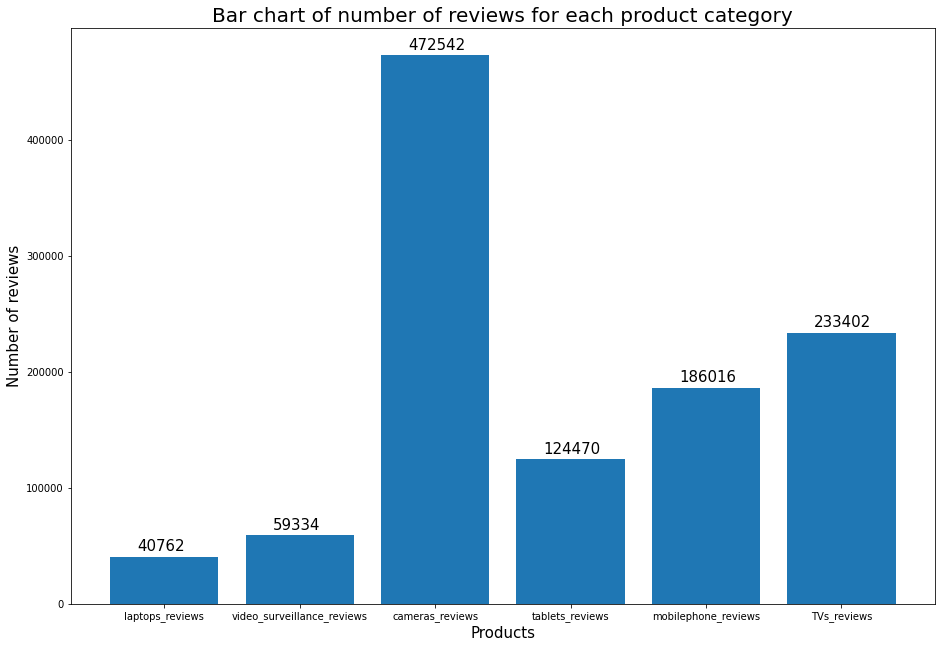

In [2]:
data_path = './Data'

plot_num_reviews_per_category(data_path)

## Check for NA/empty reviews content
- From the output, we can see that there are NA values in 'Content' and 'Product_Name' columns. Rows with NA value in these columns are not useful in analysis.

In [3]:
file_path = './Data'
csv_files = [filename for filename in os.listdir(file_path) if filename.endswith('reviews.csv')]

for filename in csv_files:
    df = pd.read_csv(f'{file_path}/{filename}')
    print(' '* 10 + filename[:-4] + ' '* 10)
    print('-'*50)
    print(df.info())
    print()

          laptops_reviews          
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40762 entries, 0 to 40761
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         40762 non-null  int64  
 1   Title              40761 non-null  object 
 2   Author             40693 non-null  object 
 3   ReviewID           40762 non-null  object 
 4   Overall            40762 non-null  float64
 5   Content            40744 non-null  object 
 6   Date               40760 non-null  object 
 7   Product_ProductID  40762 non-null  object 
 8   Product_Name       20670 non-null  object 
 9   Product_Features   20554 non-null  object 
 10  Product_Price      19377 non-null  object 
 11  Product_ImgURL     20647 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 3.7+ MB
None

          video_surveillance_reviews          
----------------

## Check for spam/duplicate comments
- Contains duplicates, go to excel to check in details

In [4]:
for filename in csv_files:
    df = pd.read_csv(f'{file_path}/{filename}')
    print(f"Total comments in {filename[:-12]} category is: {len(df['Content'])}")
    print(f"Unique comments in {filename[:-12]} category is: {len(df['Content'].unique())}")
    print()

Total comments in laptops category is: 40762
Unique comments in laptops category is: 36472

Total comments in video_surveillance category is: 59334
Unique comments in video_surveillance category is: 44468

Total comments in cameras category is: 472542
Unique comments in cameras category is: 220261

Total comments in tablets category is: 124470
Unique comments in tablets category is: 65110

Total comments in mobilephone category is: 186016
Unique comments in mobilephone category is: 149984

Total comments in TVs category is: 233402
Unique comments in TVs category is: 114488



# Data Cleaning 
<br>

### - Merging standardized Product ID to every products' reviews dataframe
- For a product base model, there may be several different product names and product ID. Hence, manual work was put in to standardize the Product IDs for all product names which are actually referring to the same base model. 

### - Remove NA rows
### - Remove Spam/Duplicates rows

In [5]:
file_path = './Data'
prod_IDs_path = './Data/ProductIDs/'
data_files = [filename for filename in os.listdir(file_path) if filename.endswith('reviews.csv')]
data_files.sort()
prod_IDs_files = [filename for filename in os.listdir(prod_IDs_path) if filename.endswith('.csv')]
prod_IDs_files.sort()
print("Data files order:\n", data_files)
print()
print("Product IDs files order:\n",prod_IDs_files)

Data files order:
 ['TVs_reviews.csv', 'cameras_reviews.csv', 'laptops_reviews.csv', 'mobilephone_reviews.csv', 'tablets_reviews.csv', 'video_surveillance_reviews.csv']

Product IDs files order:
 ['TVs_products.csv', 'cameras_products.csv', 'laptops_products.csv', 'mobilephone_products.csv', 'tablets_products.csv', 'video_surveillance_products.csv']


In [6]:
for i in range(len(data_files)):
    reviews = pd.read_csv(f'{file_path}/{data_files[i]}', index_col=0)
    products = pd.read_csv(f'{prod_IDs_path}/{prod_IDs_files[i]}', index_col=0).reset_index()
    products.drop('Counts', axis=1, inplace=True)
    products.rename(columns={'Product': 'Product_Name'}, inplace=True)

    # merging the standardized product IDs to reviews dataframs
    merged = pd.merge(reviews, products, how='left', on=['Product_Name'])
    merged.drop(['Product_ProductID', 'Product_ImgURL', ], axis=1, inplace=True) # drop original product ID column and product image URL (not meaningful in our analysis)
    print(data_files[i][:-12])
    print('-'*10)
    print(f'Before cleaning: {len(merged)}')

    # drop rows if there is NA is either Product_Name/Review Content columns
    merged.dropna(subset=['Product_Name'], inplace=True)
    merged.dropna(subset=['Content'], inplace=True)

    # drop duplicates/spam 
    spam_removed = drop_duplicate_spam(merged)
    print(f'After cleaning: {len(spam_removed)}')
    print()

    spam_removed.to_csv(f'{file_path}/Cleaned Data/{data_files[i]}')

TVs
----------
Before cleaning: 257996
After cleaning: 217558

cameras
----------
Before cleaning: 484159
After cleaning: 224139

laptops
----------
Before cleaning: 40821
After cleaning: 19898

mobilephone
----------
Before cleaning: 202280
After cleaning: 145316

tablets
----------
Before cleaning: 140785
After cleaning: 45049

video_surveillance
----------
Before cleaning: 64645
After cleaning: 50721



## Creating a bar chart for number of reviews against each product category

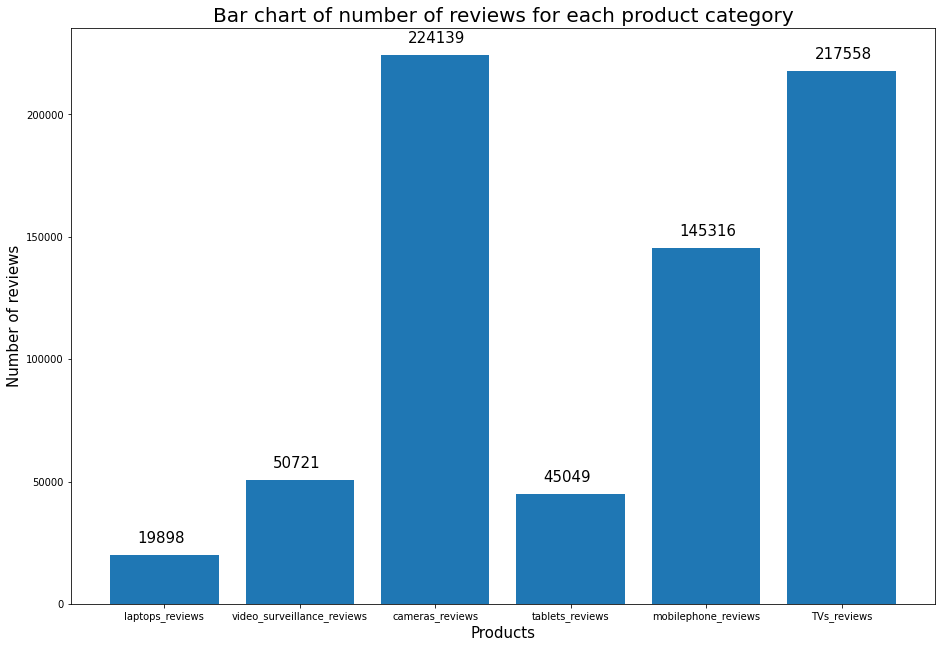

In [7]:
plot_num_reviews_per_category('./Data/Cleaned Data')

# Getting sentiment for a product model

### Getting top 10 negative sentiment for a product model

In [2]:
get_top_negative_reviews(category='laptops', pid='B002C74D7A', n=10)

Product ID:
   - B002C74D7A

Product Name:
   - Apple MacBook Pro MC725LL/A 17-Inch Laptop (OLD VERSION)

----------------------------------------------------------------------------------------------------

Rank 1 review:
Too bad I don't know how to use a Mac or it would be mine instead of my wife's.

Rank 2 review:
Unfortunately unless you order from Apple there's no way to add the high-res display (1680x1050).

Rank 3 review:
For example, I had an Outlook utility that allowed 1 or 2-click email filing when sent or read - I cannot find anything like that for Mac Outlook, and I am very sorry not to have it.

Rank 4 review:
The next day when I contacted the seller - because of a really lame lie he told - I fully understood at that time I had become the victim of fraud.However, because Amazon would not allow me to file a fraud claim until a full 26-27 days after the sale date, I did not get a timely refund, and I was forced to watch as the unscrupulous seller sold the same non-existant 

### Getting top 5 positive sentiment for a product model

In [3]:
get_top_positive_reviews(category='laptops', pid='B002C74D7A', n=5)

Product ID:
   - B002C74D7A

Product Name:
   - Apple MacBook Pro MC725LL/A 17-Inch Laptop (OLD VERSION)

----------------------------------------------------------------------------------------------------

Rank 1 review:
The battery life is excellent and the screen resolution is excellent

Rank 2 review:
Perfect Screen resolution for content creation work.

Rank 3 review:
I would like to let people know more than just about how great this laptop is, i want to let them also know how great amazon was from start to finish!

Rank 4 review:
THIS THING IS THE BEST LAPTOP I HAVE EVER USED IN MY LIFE!...

Rank 5 review:
Great job Apple!



# Topic Modelling

### Set the Mallet path

In [3]:
os.environ.update({'MALLET_HOME':r'/Users/chenjianyu/NLP_Text_Processing/mallet-2.0.8'})
mallet_path = r'/Users/chenjianyu/NLP_Text_Processing/mallet-2.0.8/bin/mallet' 

 ### Perform Topic Modelling for a product/category
 - Create an array of docs from corpus after preprocessing
 - Create dictionary from a corpus
 - Create BOW vectors for each document

In [4]:
category = 'laptops' # input the category type
product_id = 'B002C74D7A' # input any product id under the category type
addtional_stop_words = ['laptop', 'laptops'] # list additional stopwords if needed

df = get_category_reviews(category)
# df = get_product_reviews(category=category, product_id=product_id)

stop_list = nltk.corpus.stopwords.words('english')
stop_list = stop_list + addtional_stop_words

docs = corpus2docs(df=df, stop_list=stop_list)
dic = gensim.corpora.Dictionary(docs)
vecs = docs2vecs(docs=docs, dic=dic)

- Get the coherence scores

In [5]:
coherence_scores = get_coherence_scores(mallet_path=mallet_path, docs=docs, dic=dic, vecs=vecs)

#Topics: 2 Score: 0.2597184840025114
#Topics: 3 Score: 0.33710037019640327
#Topics: 4 Score: 0.4280921654513449
#Topics: 5 Score: 0.5072228921346132
#Topics: 6 Score: 0.5021877370468701
#Topics: 7 Score: 0.5082665992553315
#Topics: 8 Score: 0.5519861509911164
#Topics: 9 Score: 0.5457624972390449
#Topics: 10 Score: 0.551672624789868
#Topics: 11 Score: 0.5531220858247127
#Topics: 12 Score: 0.5877321744375819
#Topics: 13 Score: 0.5765616742499988
#Topics: 14 Score: 0.5758024585217788


- Plot the coherence scores

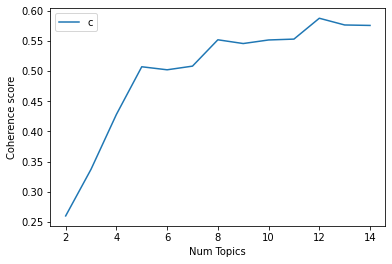

In [6]:
coherence_plot(limit=15, coherence_values=coherence_scores)

- After determining the number of topics, train LdaMallet model and get top words under each topic

In [7]:
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=vecs, iterations=500, num_topics=5, id2word=dic, random_seed=99)

# getting the top words for each topic
get_topics(lda_mallet=lda_mallet, no_topics=5)

(0, '0.047*"screen" + 0.032*"keyboard" + 0.025*"drive" + 0.019*"hard" + 0.016*"nice" + 0.015*"touch" + 0.014*"light" + 0.013*"tablet" + 0.011*"usb" + 0.010*"mouse" + 0.010*"pad" + 0.010*"small" + 0.009*"size" + 0.009*"power" + 0.009*"big" + 0.008*"keys" + 0.008*"easy" + 0.008*"feel" + 0.008*"touchpad" + 0.007*"display"')

(1, '0.028*"computer" + 0.021*"bought" + 0.020*"macbook" + 0.020*"buy" + 0.017*"apple" + 0.016*"product" + 0.016*"asus" + 0.013*"amazon" + 0.013*"recommend" + 0.012*"pro" + 0.011*"years" + 0.011*"dell" + 0.011*"purchase" + 0.010*"purchased" + 0.009*"model" + 0.009*"happy" + 0.009*"back" + 0.009*"support" + 0.008*"year" + 0.008*"money"')

(2, '0.033*"battery" + 0.030*"time" + 0.019*"life" + 0.017*"problem" + 0.017*"thing" + 0.016*"windows" + 0.015*"hours" + 0.012*"problems" + 0.011*"issue" + 0.011*"back" + 0.010*"day" + 0.010*"issues" + 0.010*"long" + 0.009*"working" + 0.009*"bad" + 0.008*"update" + 0.008*"found" + 0.008*"make" + 0.008*"find" + 0.007*"times"')

(3, '0.

- Create a pyLDAvis plot for the topics for easier visualization and evaluation

In [8]:
create_pyLDAvis(lda_mallet, vecs, dic, 'laptop')

- Label each setences by its most dominant topic

In [9]:
df_dominant_topic = format_topics_sentences(ldamodel=lda_mallet, corpus=vecs, data=docs, ori_data=df)
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Tokenized Text,Content
0,0,3.0,0.2182,"great, good, price, fast, machine, works, qual...","[ram, ssd, months, paid, lot, first, came]",I've had the S7-391 with 4Gb RAM and a 256 GB ...
1,1,1.0,0.2162,"computer, bought, macbook, buy, apple, product...","[recommend, understand, limitations, problems,...","I can recommend it, but only if you understand..."
2,2,2.0,0.2203,"battery, time, life, problem, thing, windows, ...","[quick, summary, experience, date, goodit, thi...",Here's a quick summary of my experience to dat...
3,3,0.0,0.2321,"screen, keyboard, drive, hard, nice, touch, li...","[screen, excellent, resolution, reasonably, re...",The screen has excellent resolution and reason...
4,4,0.0,0.2242,"screen, keyboard, drive, hard, nice, touch, li...","[since, turns, open, need, actually, shut, car...","Since it turns itself on when you open it, you..."


- To further check if LdaMallet is working well, we filter out all the sentences under a topic and evaluate the sentences

In [10]:
topic_3 = get_reviews_by_topic(df_dominant_topic, 3.0)
topic_sample = topic_3['Content'].sample(n=10, random_state=10)
for i, sent in enumerate(topic_sample):
    print(f'Sentence {i+1}')
    print(sent)
    print()

Sentence 1
And just as quickly as on my $1000 2012 ssd mac mini.I was afraid that I wouldn't be able to do much, but I continue to be pleasantly surprised.

Sentence 2
are so impressive.

Sentence 3
It still looks good as new unless you search for where the dent was (I carefully banged it out with a hammer).My next upgrade will obviously be a new MBP with probably no optical drive (who needs 'em with internet speeds as fast as they are these days?)

Sentence 4
I even use the high output in my power management.

Sentence 5
Secondly, do run higher profile games and it functions properly on medium to high quality, but when I go to play Minecraft on full screen it starts to have image "ribbon flares" across the screen near your hand.It is a really good computer for the price.

Sentence 6
The laptop frame has a lot of metal casing around it, producing a fairly high build quality.

Sentence 7
It also doesn't heat up, like my previous laptops have.-Slots.

Sentence 8
They have horrible perfor

# Semi-supervised Topic Modelling (CorEx)

- As we can see from the LdaMallet topic modelling, topics generated may not be definitive and relevant to what users require. 
- Thus, we can implement semi-supervised topic modelling to enhance to topics generated

 ### Creating the BOW model and all the unique words in the corpus

In [12]:
category = 'laptops'
df = get_category_reviews(category)

vecs, vocab = get_corex_vectorizer_vocab(df=df)
len(vocab)

571845

### Creating anchor words for CorEx model to guide words to fall into each guided topic we create

In [13]:
anchor_words = [
    # Topic 1: Battery Life
    ['battery', 'battery life', 'lasting', 'long battery'],

    # Topic 2: System Performance
    ['processor', 'ssd', 'hard drive', 'ram', 'memory', 'storage', 'gpu', 'graphics', 'graphics card'], 

    # Topic 3: Operating System
    ['windows', 'mac', 'apple', 'macbook', 'software', 'system', 'install', 'application', 'program', 'run', 'running', 'operating', 'version', 'win'], 

    # Topic 4: Price
    ['price', 'cheap', 'expensive', 'affordable', 'cost', 'money', 'budget', 'value', 'worth'], 

    # Topic 5: Ports
    ['port', 'hdmi', 'usb', 'vga', 'adapter'],

    # Topic 6: Asethetics/Weight
    ['sleek', 'heavy', 'light', 'lightweight', 'weight', 'design', 'feels', 'slim', 'portable', 'portability', 'build quality', 'rugged', 'ruggedness'], 

    # Topic 7: Post Sales/Service
    ['warranty', 'support', 'customer support', 'customer service', 'service'],

    # Topic 8: Peripheral
    ['screen', 'keyboard', 'size', 'mousepad', 'mouse pad', 'mouse', 'keys', 'touchpad', 'touch pad', 'trackpad', 'track pad', 'button', 'touch', 'resolution', 'clear', 'touchscreen', 'touch screen', 'bright', 'pixel', 'speakers']
]

### Training the CorEx model

In [14]:
anchored_topic_model = ct.Corex(n_hidden=10, seed=2)
anchored_topic_model.fit(vecs, words=vocab, anchors=anchor_words, anchor_strength=6)

### Getting the top words for each topic

In [15]:
print_corex_top_topic_words(model=anchored_topic_model, n_words=30)

Topic #1: battery, battery life, life, long battery, hours, lasting, long, charge, hours battery, power, lasts, life hours, great battery, battery lasts, good battery, hour, life good, plugged, hour battery, battery does, laptop battery, longer, life great, lasts hours, battery power, hrs, battery hours, charged, battery charge, new battery

Topic #2: ram, hard drive, processor, graphics, ssd, memory, storage, graphics card, gpu, drive, hard, core, intel, card, games, cpu, upgrade, nvidia, hdd, solid state, ghz, space, dual, state, performance, play, amd, rpm, intel core, settings

Topic #3: windows, macbook, apple, mac, software, run, running, version, install, operating, program, win, application, macbook pro, pro, macbook air, air, programs, windows laptop, apple store, new macbook, like windows, used windows, use windows, vista, installed, run windows, mac book, apple products, windows vista

Topic #4: price, money, worth, cheap, cost, value, expensive, budget, affordable, great pr

### Plot the total correlation plot to check the correlation score for each topic

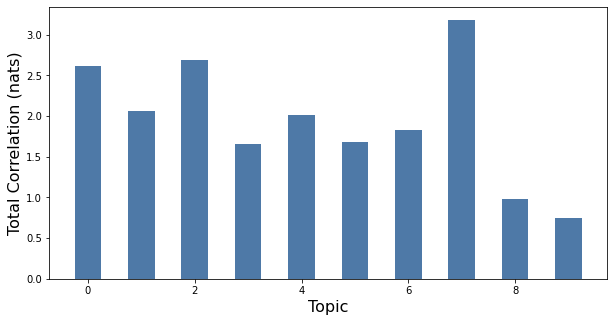

In [16]:
plot_corex_total_correlation(model=anchored_topic_model)

### Label topics for each sentences

In [17]:
dominant_topics = corex_label_topics(df=df, model=anchored_topic_model, vecs=vecs, no_topics=10)
dominant_topics.head(3)

,index,Content,Product_Name,ProductID,Reviews,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,0,I've had the S7-391 with 4Gb RAM and a 256 GB ...,Acer Aspire S7-391-6468 13.3-Inch Touchscreen ...,B00HSYS3LO,had the with ram and ssd for about months havi...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,"I can recommend it, but only if you understand...",Acer Aspire S7-391-6468 13.3-Inch Touchscreen ...,B00HSYS3LO,can recommend but only you understand the limi...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,Here's a quick summary of my experience to dat...,Acer Aspire S7-391-6468 13.3-Inch Touchscreen ...,B00HSYS3LO,here quick summary experience date goodit very...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### Get sentences under a productID of interest

In [19]:
product_reviews = dominant_topics[dominant_topics['ProductID'] == 'B002C74D7A']

### Get sentences under a topic for a product

In [42]:
df_topic1 = product_reviews[product_reviews['topic_1'] == 1.0]
sample_sentences = df_topic1['Content'].sample(n=10, random_state=15)
for i, sent in enumerate(sample_sentences):
    print(f'Sentence {i+1}')
    print(sent)
    print()

Sentence 1
The battery is in real world use about an 5'ish hour battery!

Sentence 2
the video is amazing, everything is just so fast, and battery lasts so long i hardly have to charge it.

Sentence 3
When I went into an Apple Store, I quite literally found myself envisioning a particular niche need for each of their MacBook Air 11", 13", MacBook Pro 13", 15", and 17" models!In the end, I decided that the MBP 13" screen was too small for my needs and although the i5 and i7 CPUs in the MBP 13" were significantly faster than the previous generation CPUs, they actually underperformed the previous generation in their graphics intensive applications as the integrated Intel GPU was not as robust as the older generation MBP 13" models.That left the MBP 15" and 17" models with screen sizes suitable for my needs.

Sentence 4
******Pros:*The Anti-Glare is super-nice, much better than standard Matte-displays*Wonderful display*Unibody & Glass Trackpad makes for an ultimate seamless design*Stay's r

### Get top positive/negative reviews under a topic for a product

In [22]:
get_corex_top_positive_reviews(topics_df=df_topic1, topic=1, n=5, pid='B002C74D7A')

Product ID:
   - B002C74D7A

Product Name:
   - Apple MacBook Pro MC725LL/A 17-Inch Laptop (OLD VERSION)

----------------------------------------------------------------------------------------------------

Rank 1 review:
The battery life is excellent and the screen resolution is excellent

Rank 2 review:
Apple's argument to counteract this is to put in an even brighter display, which works, but I found having the display be bright creates a lot of discomfort for my eyes; also think of the more power you'll need to keep your screen bright compared to just having a dim anti-glare.As a result of these high-res displays, everything looks sharper anyways, and this new type of matte screen that Apple is using is much more like a glass-surface; maybe think of it as a hybrid between a matte & a glossy.

Rank 3 review:
******Pros:*The Anti-Glare is super-nice, much better than standard Matte-displays*Wonderful display*Unibody & Glass Trackpad makes for an ultimate seamless design*Stay's relat

# Subjectivity Evaluation

In [40]:
dominant_topics_sentiments = get_sentiments(dominant_topics)
subjectivity_df = get_reviews_by_subjectivity(df=dominant_topics_sentiments, subjectivity='fact') # subjectivity='opinion'

sample = subjectivity_df['Content'].sample(n=30).to_list()

for i in sample:
    print(i)
    print()

It was a gift.

I purchased this product and it took a few days for it to actually ship.

The computer randomly turns itself off when I'm in the middle of doing something.

Macs are the way to go, don't waste your time buying a Windows machine.I am upgrading from a Powerbook G4 12'', so I spent several weeks deciding between the early 2008 Pro's or the new Unibody Macbooks.

Granted, it took me awhile to get accustomed to the touchpad on the Macbook.

I purchased  the computer for traveling so I could have a thin/light computer.

I haven't seen the photo version but the graphics version actually has a photoshop-style interface option.)

I took it to an HP service provider.

Back in Moscow we took it for repair, and the same problem the shop said - no problem, you are covered by warrantee, but it will take between 7 days and 6 months to get the replacement Apple MacBook MC516LL/A 13.3-Inch LaptopApple MacBook Pro MC374LL/A 13.3-Inch Laptoppart - and we cannot tell you how long, not even

# Price vs Sentiment

In [ ]:
df = pd.read_csv('raw_review_sentiments.csv')

df = df.drop(df[df['Product_Price'] == 'Unavailable'].index)
df = df.drop(df[df['Product_Price'] == 'To see product details, add this item to your cart. You can always remove it later.'].index)

sentiments = df['final_sentiment']
prices = []
for row in df['Product_Price']:
    row = row.replace(',', '')
    row = row.replace('$', '')
    prices.append(float(row))
df['Price'] = prices
prices = np.array(prices).reshape((-1, 1))

In [ ]:
model = LinearRegression()

model.fit(prices, sentiments)
r_sq = model.score(prices,sentiments)
r_sq

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.regplot(data=df, x="Price", y="final_sentiment", ax=ax)

In [77]:
dominant_topics['opinions'] = dominant_topics['tb_subjectivity'].apply(lambda x: label_subjectivity(x))

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-77-8c411d76bc69>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topic1['opinions'] = df_topic1['tb_subjectivity'].apply(lambda x: label_opinion(x))


In [80]:
df_topic1['opinions'].value_counts()

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1    11668
0     2869
Name: opinions, dtype: int64

In [78]:
opi = df_topic1[df_topic1['opinions'] == 0]
sample = opi['Sentences'].sample(n=30).to_list()

/Users/chenjianyu/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
for i in sample:
    print(i)
    print()

I will continue to update as my usage increases and time goes on.Why get a Chromebook?For me, I am taking this to class each day and taking notes from my college professors.

By the time you get a spare battery, new video card, louder speakers, etc.. you might as well have spent the money up front.

And it really does have 8 plus hours of battery life.I am giving 4 stars, instead of 5, for two reasons.

With all I find myself doing on the computer for school and work, 3 hours of battery just didn't cut it.

Pros:battery lifeswitchable graphicslight weightno junkware.

There is also a little button above the touch pad that disables and enables the touch pad.My main concern with this laptop was, after around a year of usage, the top left screw on the bottom came loose and fell out.

However, to conserve energy I use the integrated memmory card.

For an IT professional who is used to walking into a client's server room and taking a 50GB backup copy of a database in no time via gigabit eht

In [ ]:
df = pd.read_csv('raw_review_sentiments.csv')

df = df.drop(df[df['Product_Price'] == 'Unavailable'].index)
df = df.drop(df[df['Product_Price'] == 'To see product details, add this item to your cart. You can always remove it later.'].index)

In [ ]:
sentiments = df['final_sentiment']
prices = []
for row in df['Product_Price']:
    row = row.replace(',', '')
    row = row.replace('$', '')
    prices.append(float(row))
df['Price'] = prices
prices = np.array(prices).reshape((-1, 1))


model = LinearRegression()

model.fit(prices, sentiments)
r_sq = model.score(prices,sentiments)
r_sq

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.regplot(data=df, x="Price", y="final_sentiment", ax=ax)